# Telecom Customer Churn

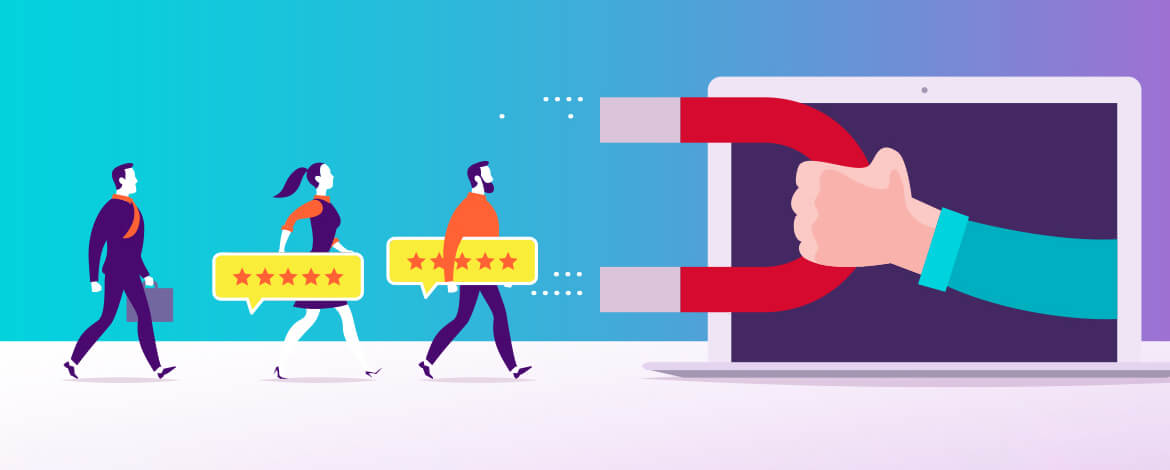

# Objectives:
### I will explore the data and try to answer some questions like:

* What's the % of Churn Customers and customers that keep in with the active services.

* We have difference pattern of churn between genders ?
* What's the difference between customers that pay monthly and by year?
* what's the most profitable service types?
* A lot of other questions that will raise trought the exploration


# Load neccesary libraries and data

In [166]:
import pandas as pd
import numpy as np
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


import matplotlib.ticker as mtick # For specifying the axes tick format 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix,precision_score, recall_score,f1_score

In [167]:
telecom_cust = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [168]:
telecom_cust.columns


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [169]:
telecom_cust.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Understanding the data

### let's first look at the churn rate in our data

In [170]:
#draw_hist(telecom_cust,'Churn')
fig = px.histogram(telecom_cust, x="Churn",  barmode="group", title="<b>Customer churn distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()




 <font size="3"> Clearly the data is skewed . We will keep this in mind in the modeling section as this will cause a lot of false negatives</font>




### General info about the data

In [171]:
telecom_cust.describe()


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [172]:
telecom_cust.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### the above output show Total charges is of type object so we'll convert it to be numeric

In [173]:
telecom_cust.TotalCharges = pd.to_numeric(telecom_cust.TotalCharges, errors='coerce')

### Plotting all categorical features:
 <font size="3"> I will plot all categorical features distributions with the % of Churn by each category</font>


In [128]:
telecom_cust_categorical = telecom_cust.drop(['customerID','tenure','MonthlyCharges', 'TotalCharges'], axis=1)
cols = list(telecom_cust_categorical.columns)

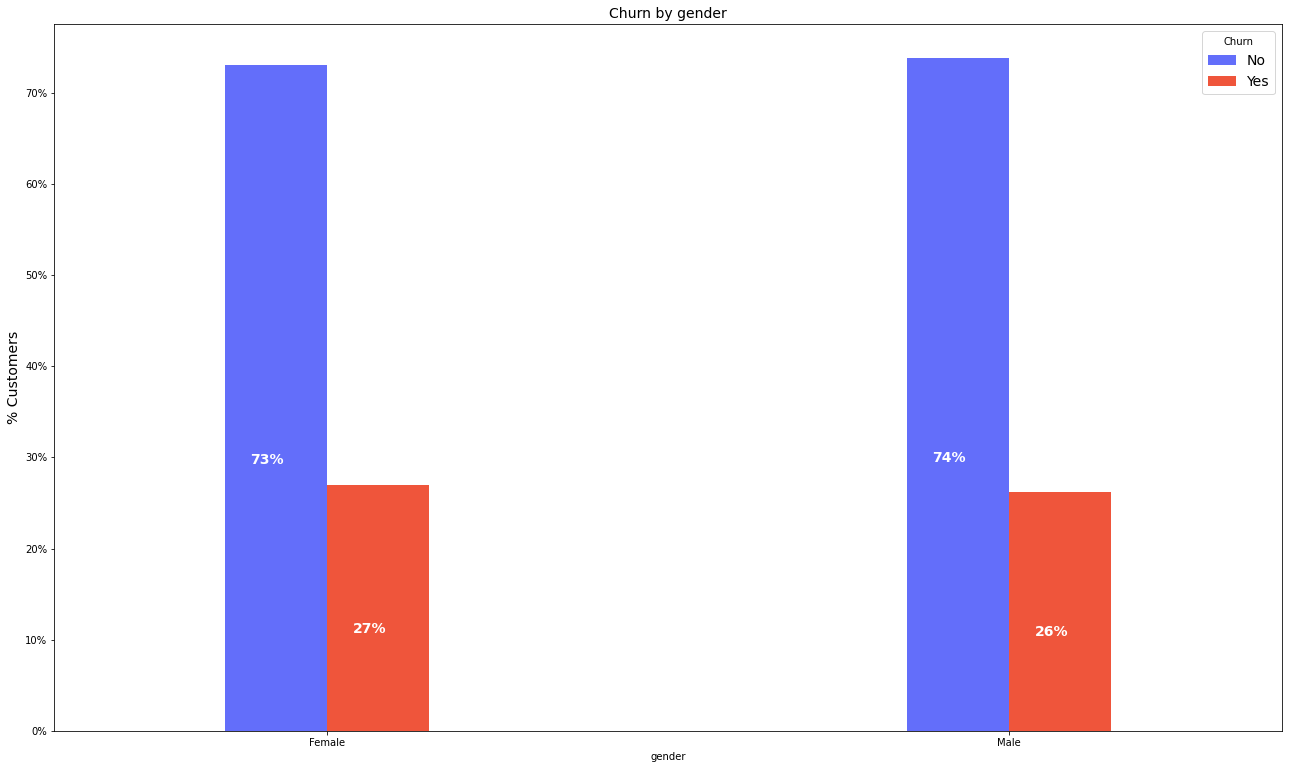

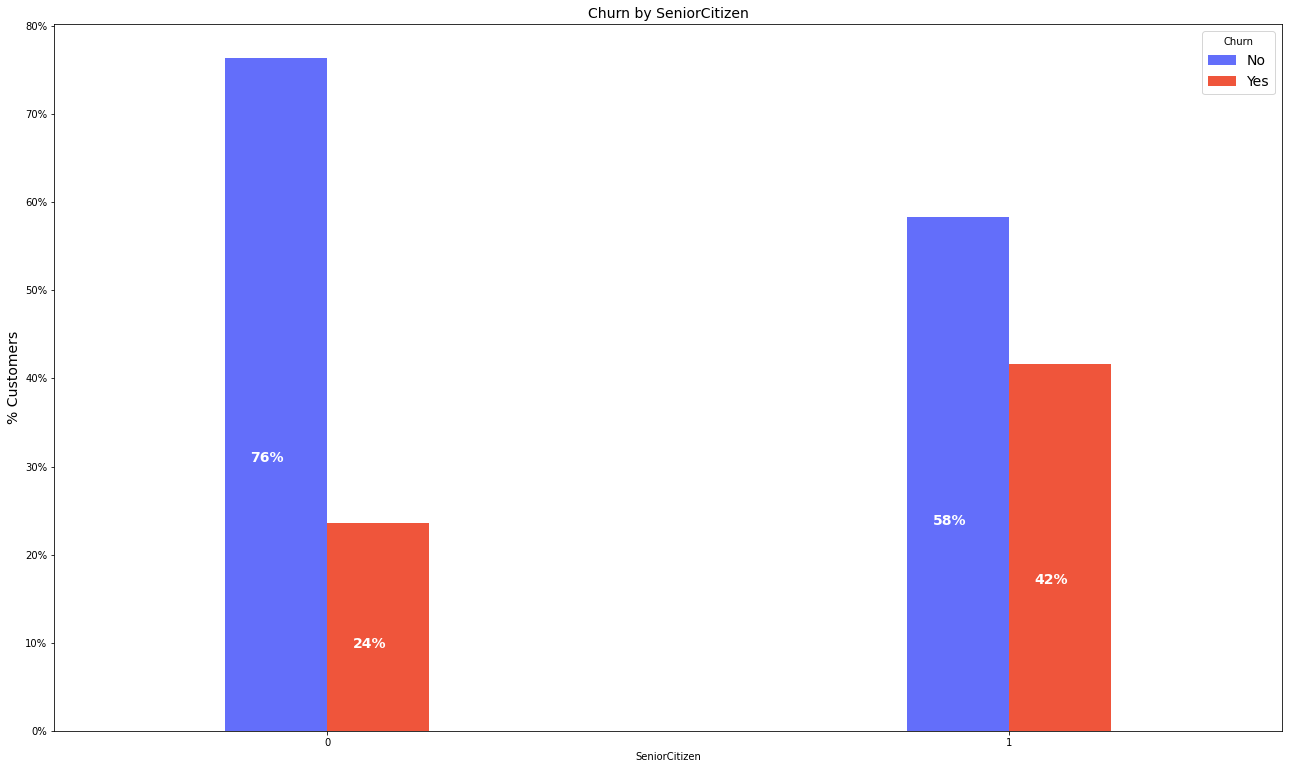

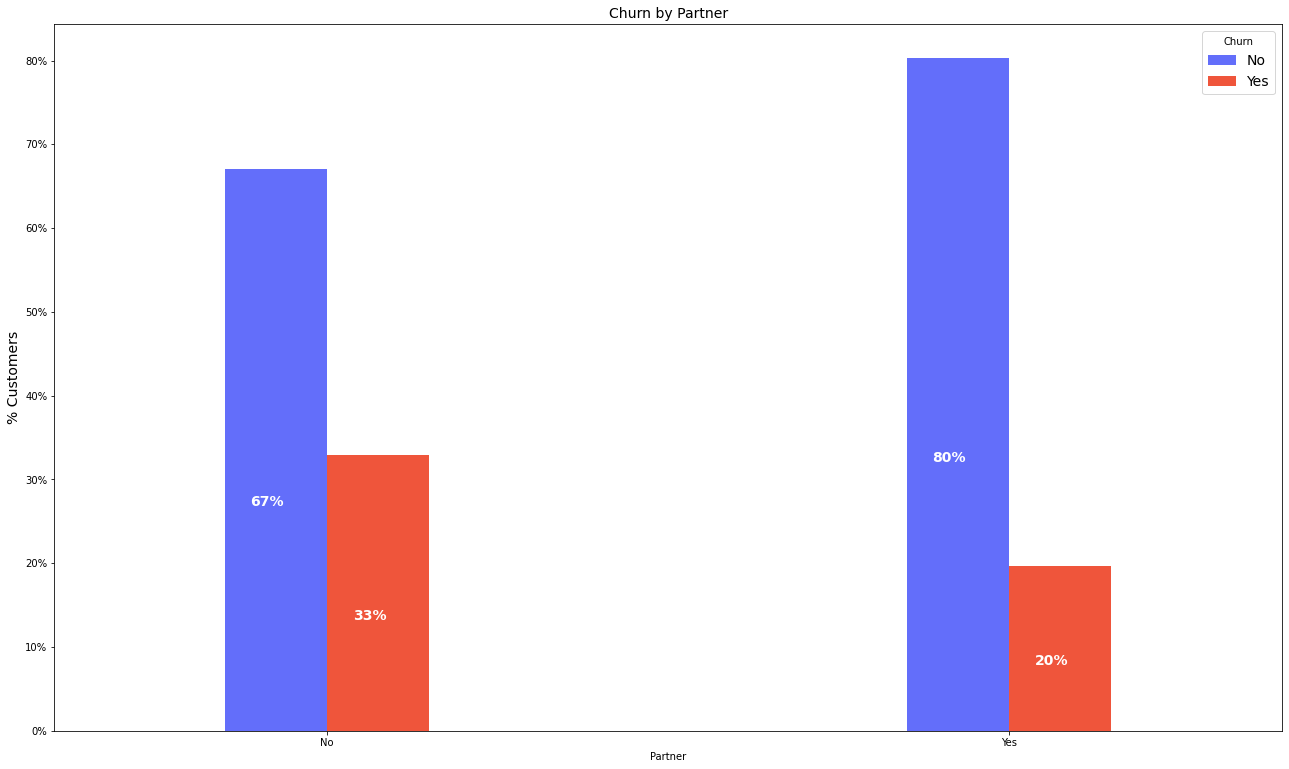

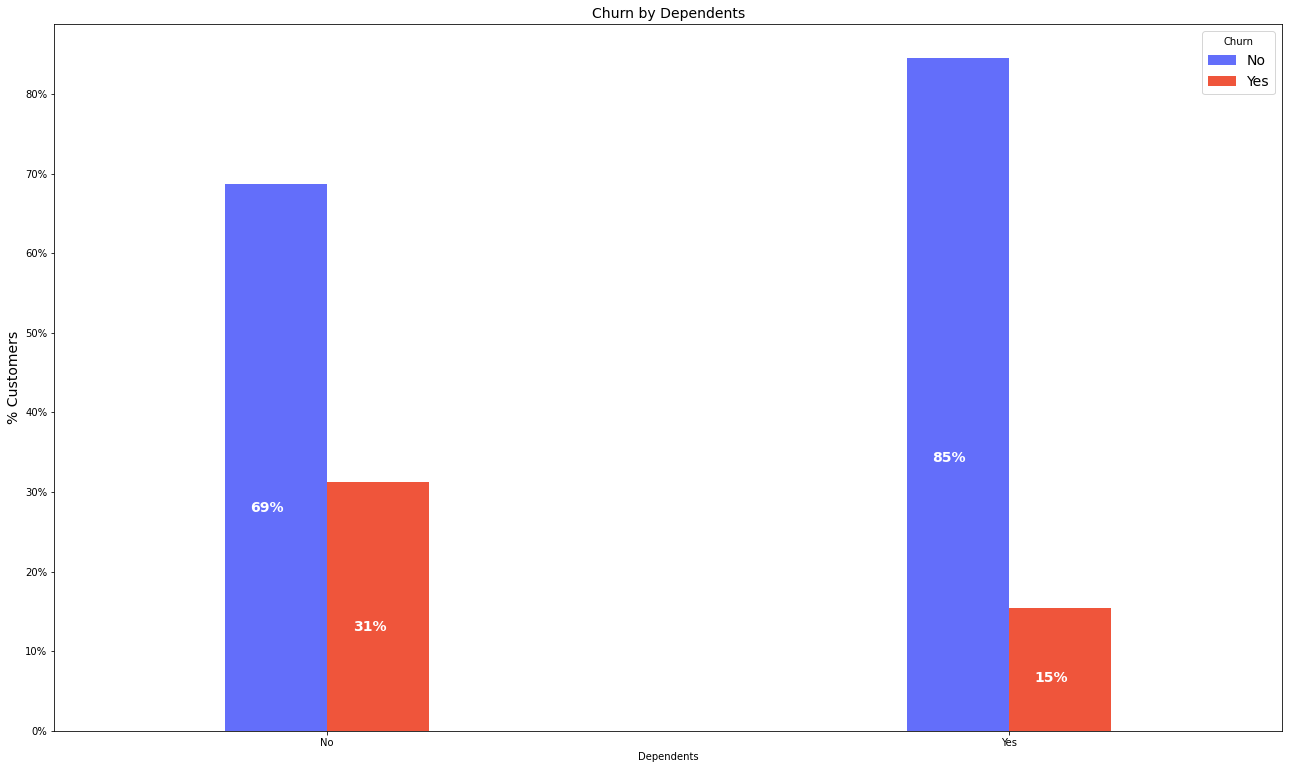

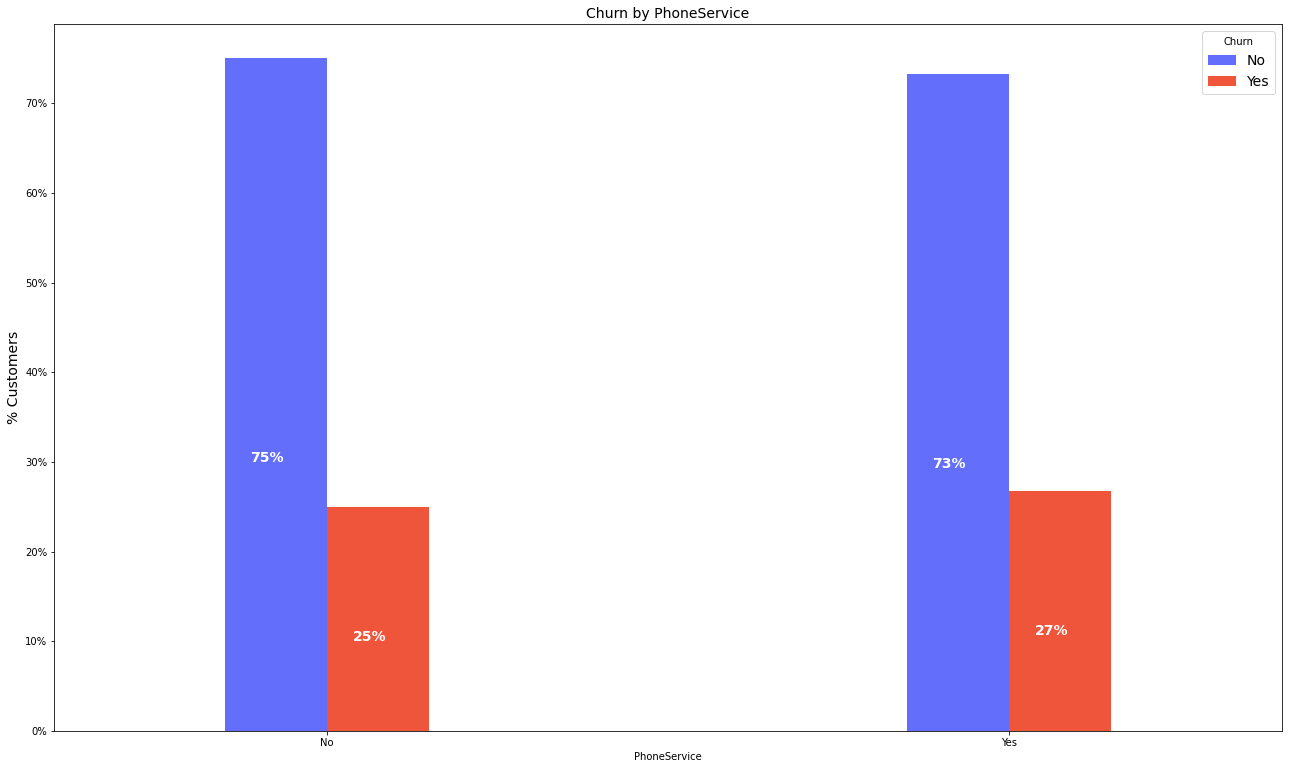

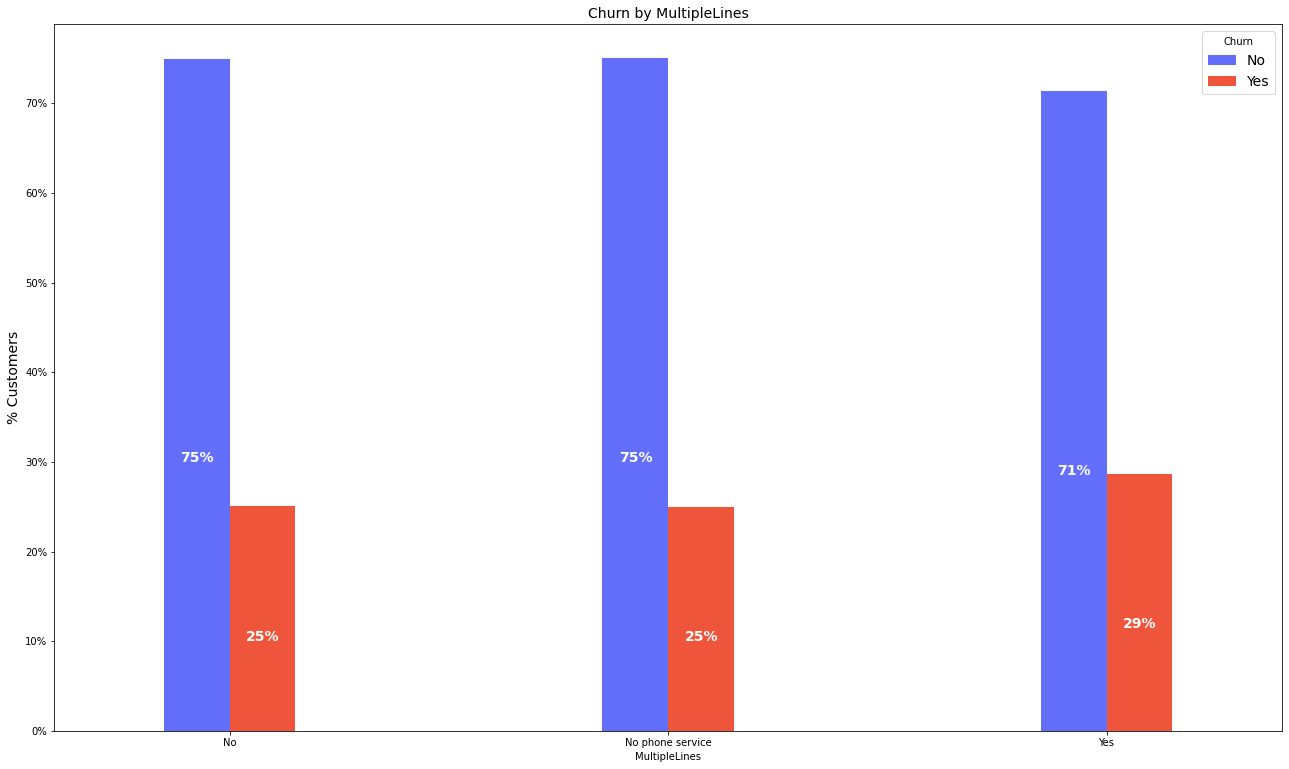

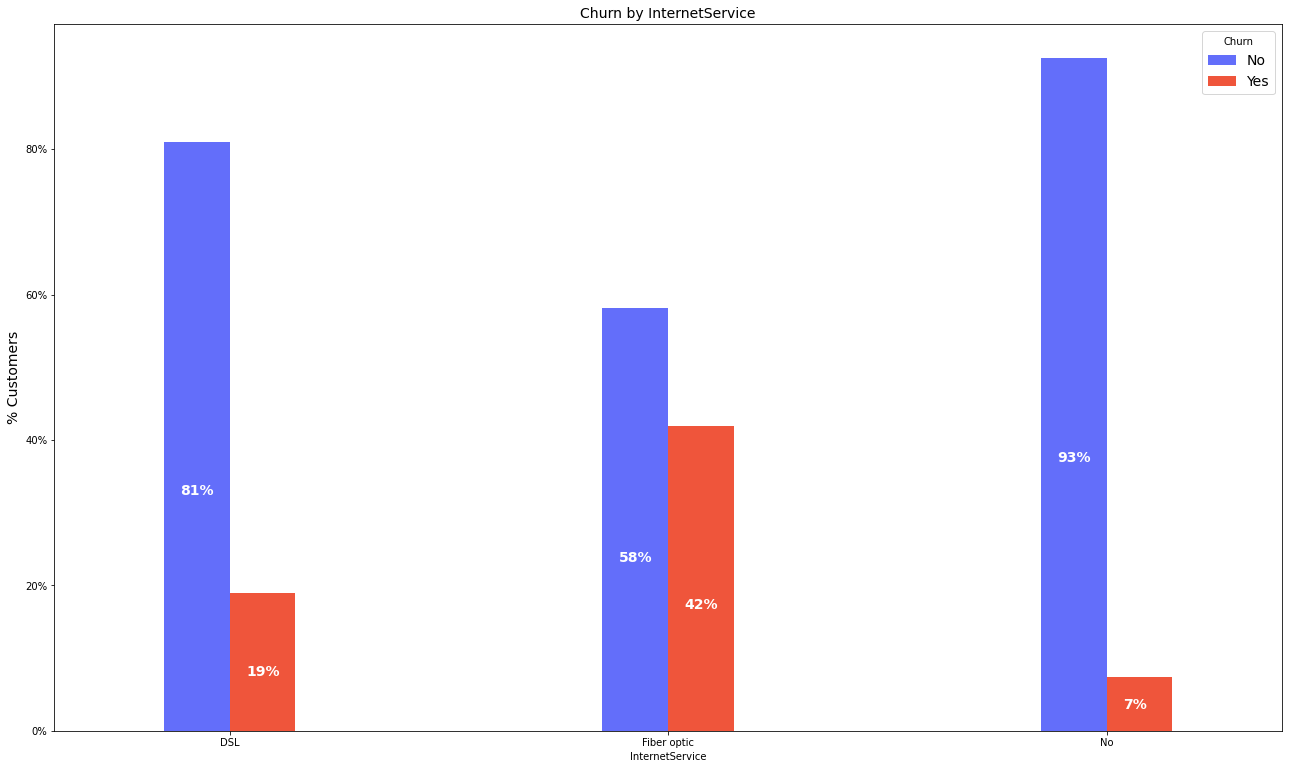

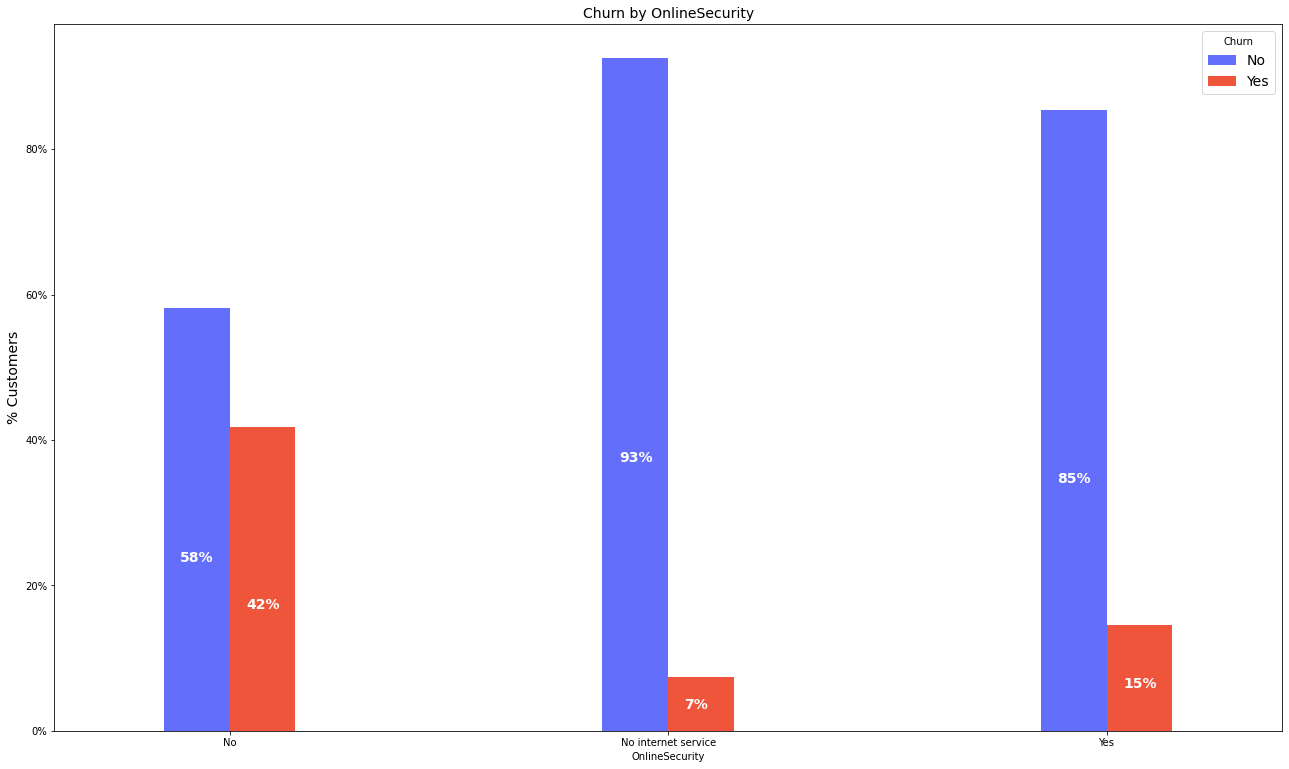

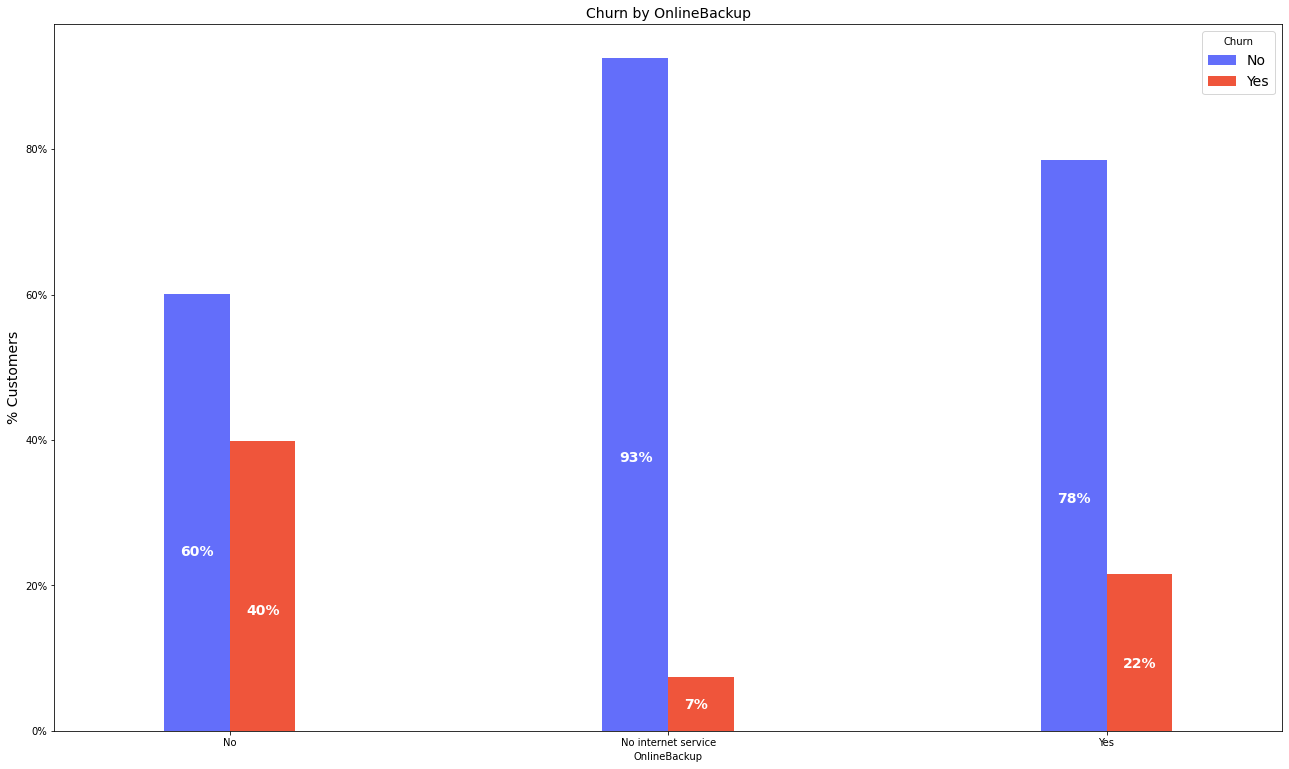

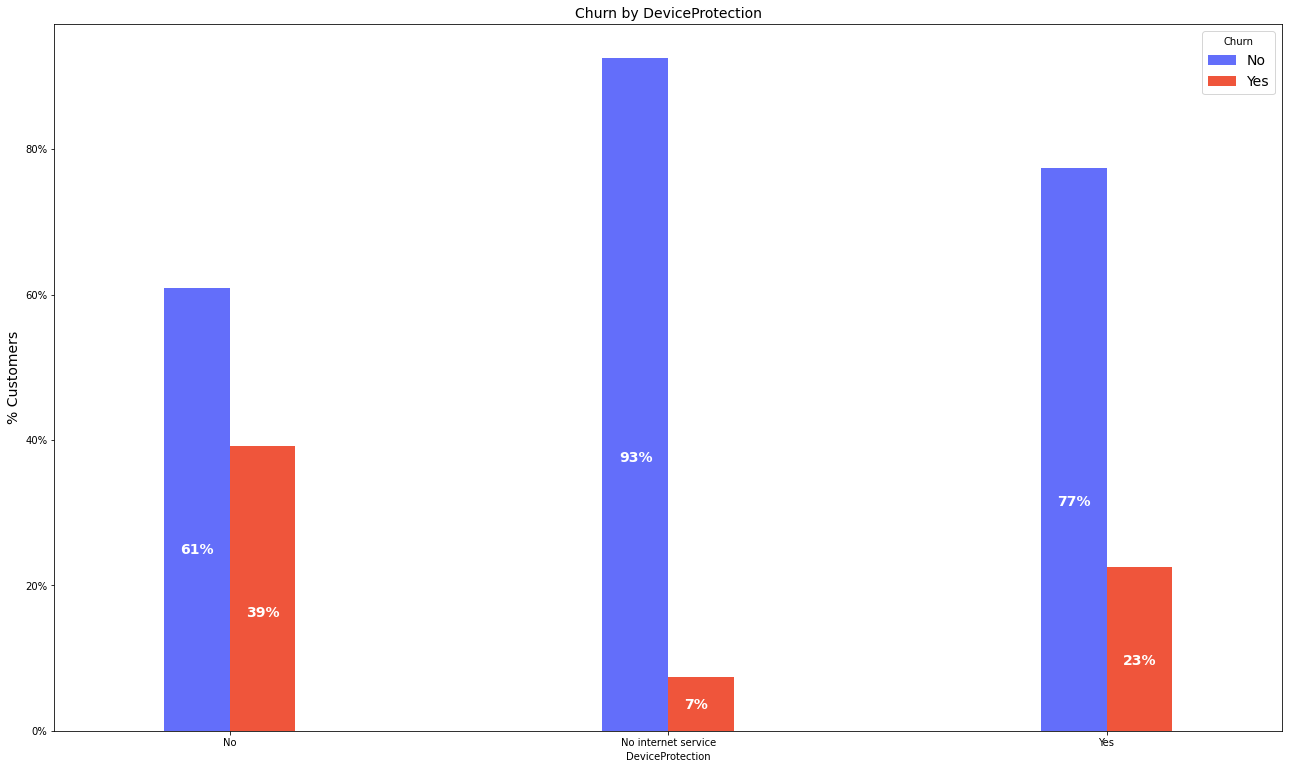

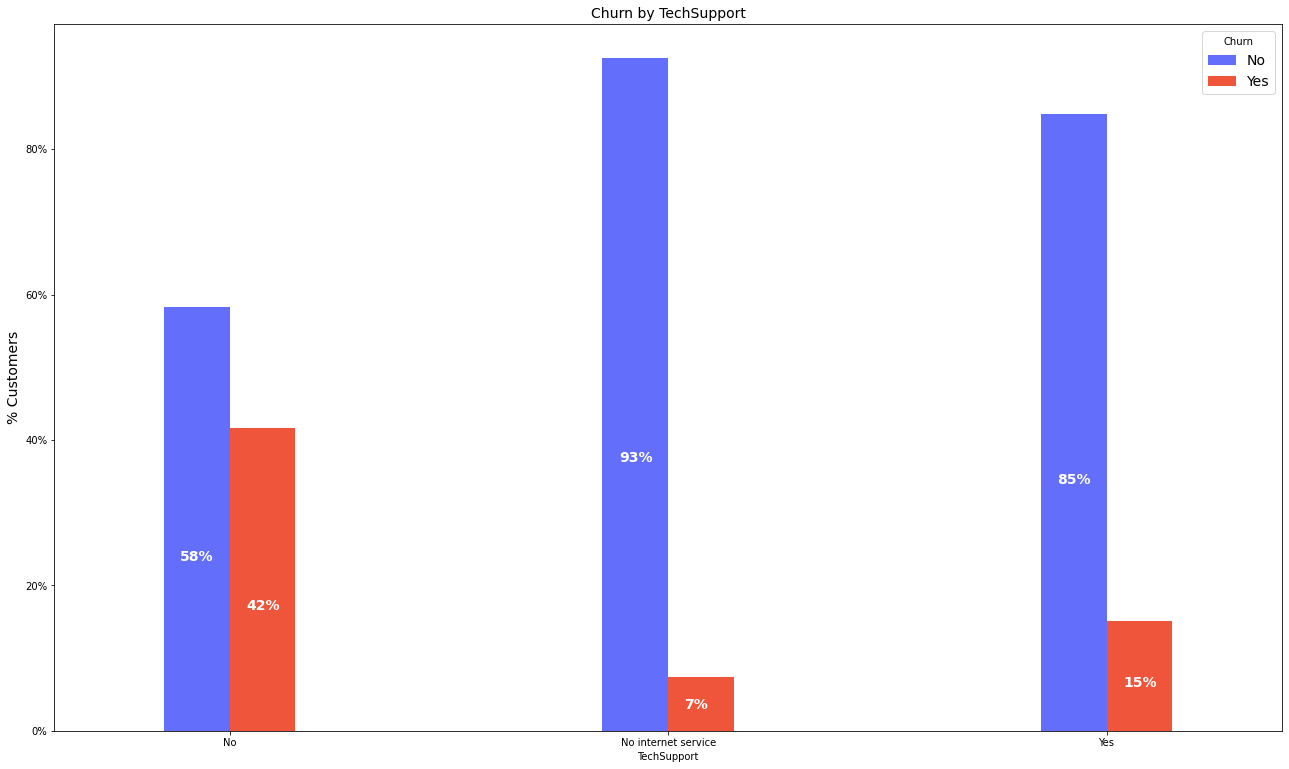

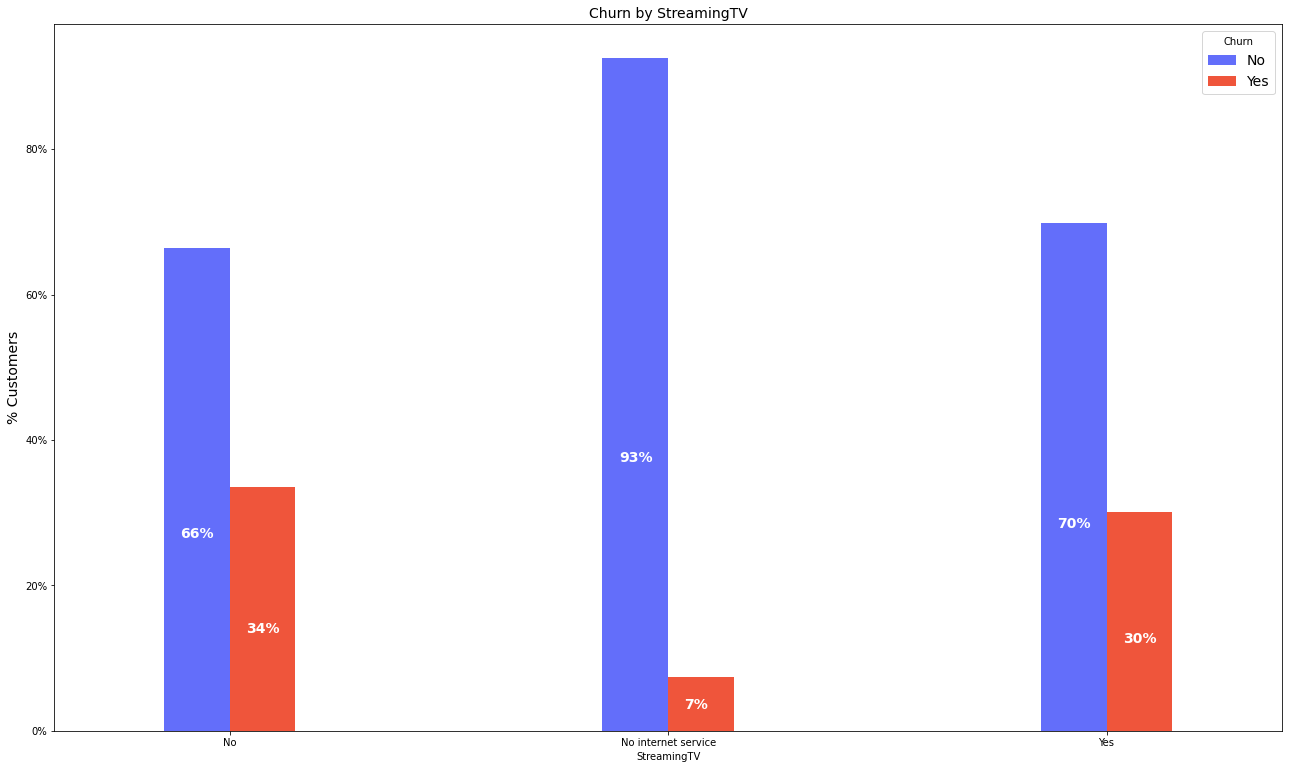

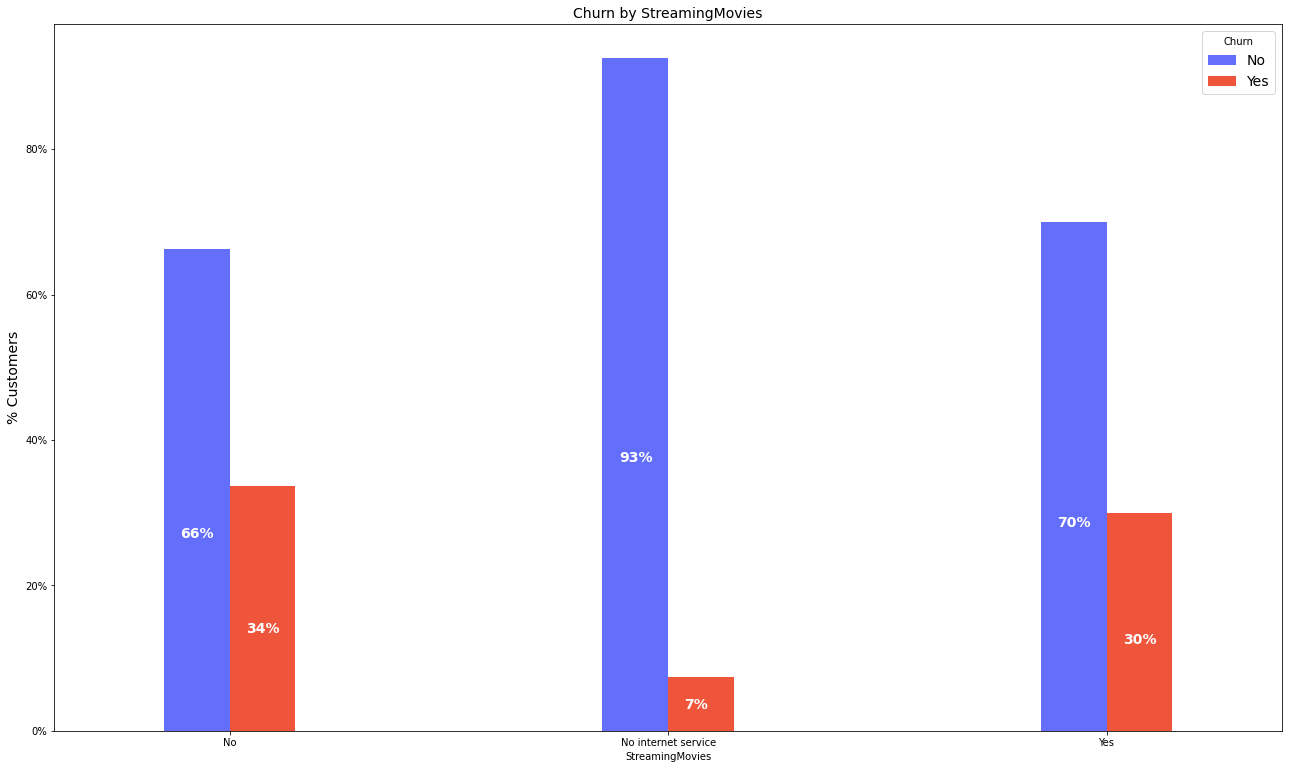

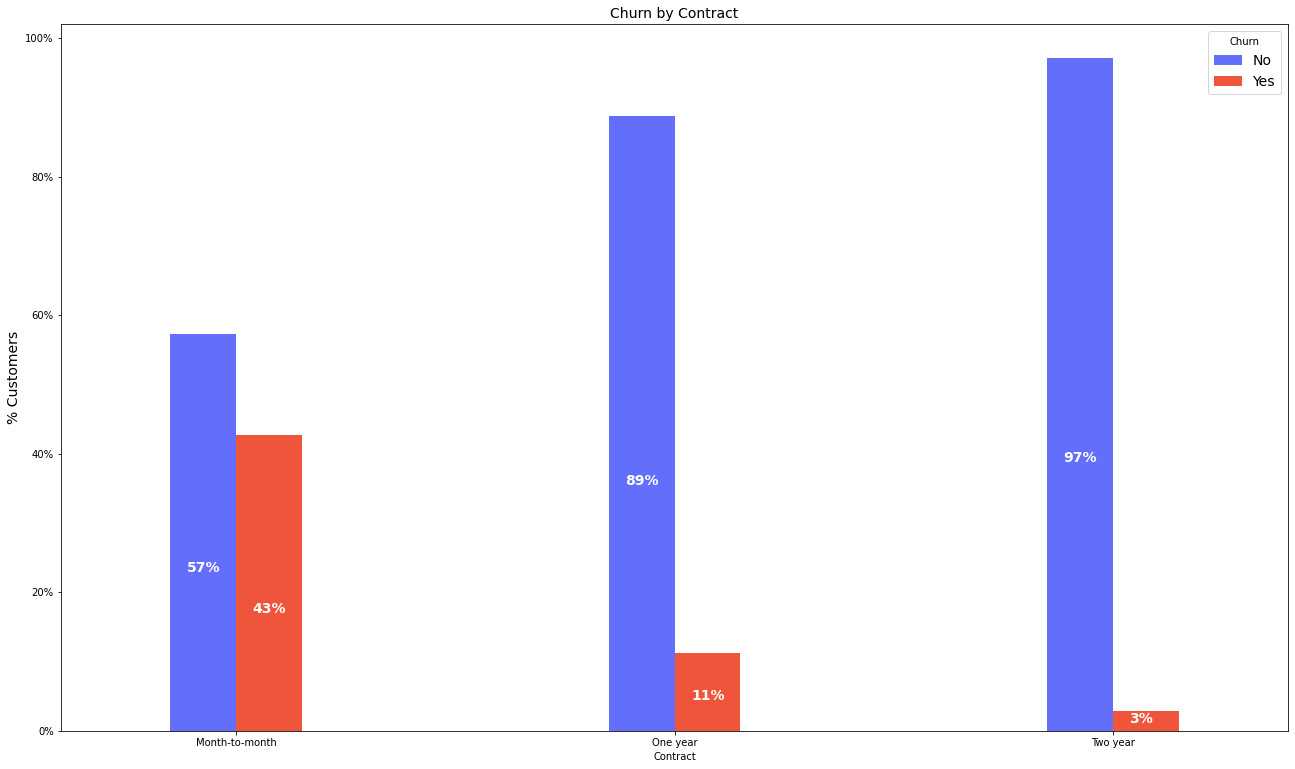

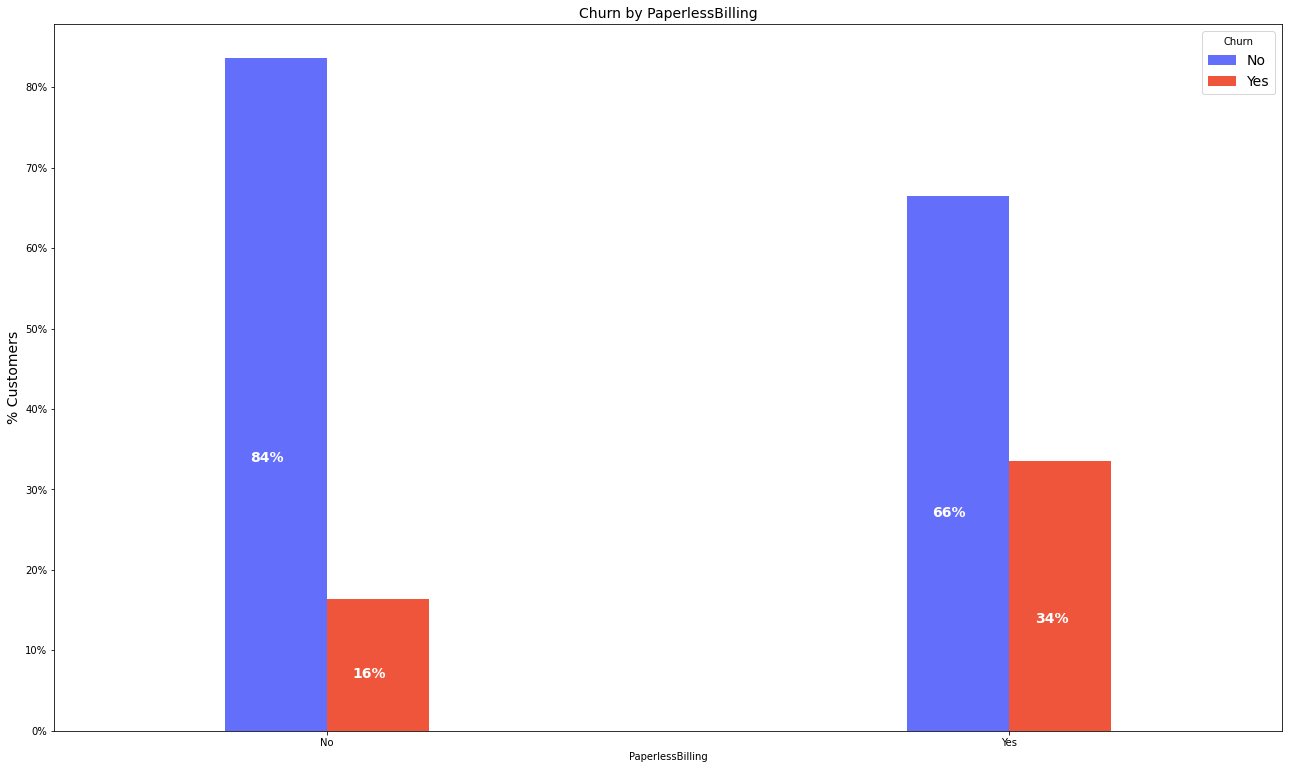

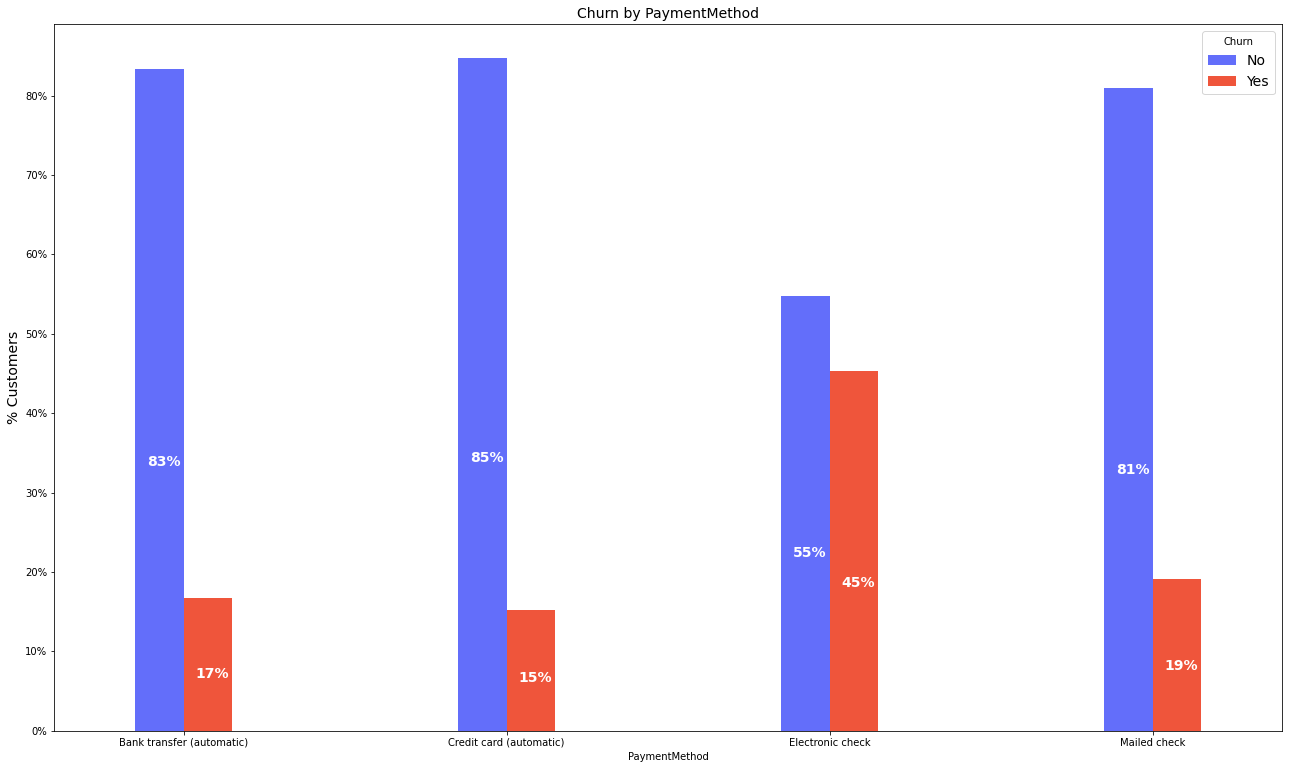

In [129]:
for i in range(len(cols) - 1):
    bar_with_churn_label(telecom_cust_categorical, cols[i])

### Analyzing the outputs we can note that:

* Gender, PhoneService, MultipleLines don't have a clear difference Churn Rates between the values in categories
* The other features seems that could be possible to help algorithmn predict Churn Customers


### Lets now explore the churn rate by tenure,  contract type, monthly charges and total charges to see how it varies by these variables



<font size = 3>i) Churn by Monthly Charges: Higher % of customers churn when the monthly charges are high. </font>

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

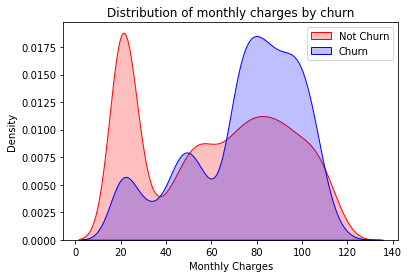

In [130]:
# VISUALIZE CONTINUOUS FEATURES WITH TARGET

# MONTHLY CHARGES
ax = sns.kdeplot(telecom_cust.MonthlyCharges[(telecom_cust["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_cust.MonthlyCharges[(telecom_cust["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of monthly charges by churn')


<font size = 3>ii) Churn by Total Charges: It seems that there is higer churn when the total charges are lower.</font>



Text(0.5, 1.0, 'Distribution of total charges by churn')

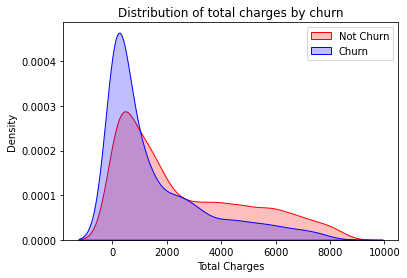

In [131]:
# TOTAL CHARGES
ax = sns.kdeplot(telecom_cust.TotalCharges[(telecom_cust["Churn"] == 'No') ],
                color="Red", shade = True)
ax = sns.kdeplot(telecom_cust.TotalCharges[(telecom_cust["Churn"] == 'Yes') ],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges by churn')


<font size = 3>iii) Churn vs Tenure: As we can see form the below plot, the customers who do not churn, they tend to stay for a longer tenure with the telecom company.
</font>

<AxesSubplot:xlabel='Churn', ylabel='tenure'>

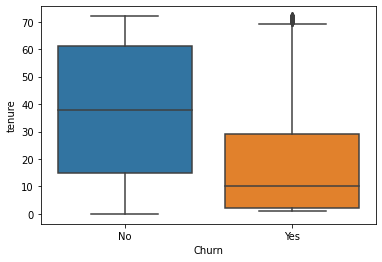

In [132]:
sns.boxplot(x = telecom_cust.Churn, y = telecom_cust.tenure)


# Data pre-processing 

### check for and drop nan, duplicates and outliers

In [134]:
# check for nan values and duplicates
print('number of nulls',telecom_cust.isnull().sum())

print('number of duplicates', telecom_cust.duplicated().sum())


number of nulls customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64
number of duplicates 0


In [135]:
telecom_cust.dropna(inplace = True)


<AxesSubplot:xlabel='TotalCharges'>

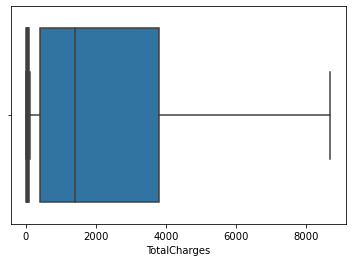

In [118]:
import seaborn as sns
sns.boxplot(x=telecom_cust['MonthlyCharges'])


<AxesSubplot:xlabel='tenure'>

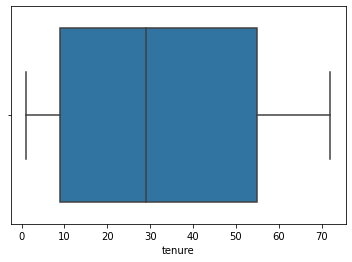

In [119]:
sns.boxplot(x=telecom_cust['tenure'])



<AxesSubplot:xlabel='TotalCharges'>

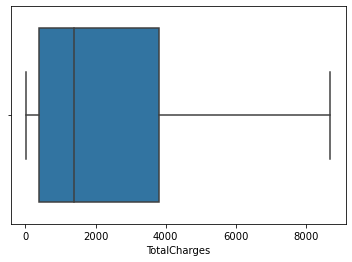

In [120]:
sns.boxplot(x=telecom_cust['TotalCharges'])


# Feature Engineering

### encode binary features, one-hot encoding, scaling numerical features

In [136]:
# number of unique values in dataframe
telecom_cust.nunique()

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

In [137]:
numericalVals = ['MonthlyCharges','TotalCharges','tenure']


nonBinaryVals = ['MultipleLines' ,'InternetService','OnlineSecurity','OnlineBackup' ,'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']
binaryVals= ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']


In [138]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, OrdinalEncoder


# the following code will encode binary features to 0/1, do one-hot encoding on features with more than 2 categories and scale numerical features

preprocessor = ColumnTransformer(transformers=[('num',MinMaxScaler(feature_range = (0,1)), numericalVals)
                                    ,('cat0',OneHotEncoder(), nonBinaryVals)
                                    ,('cat1', OrdinalEncoder(),binaryVals)
                                               ], remainder='passthrough')

preprocessor_tree = ColumnTransformer(transformers=[('cat0',OneHotEncoder(), nonBinaryVals)
                                    ,('cat1', OrdinalEncoder(),binaryVals)
                                               ], remainder='passthrough')


### One-hot encoding for features with more than 2 categories 

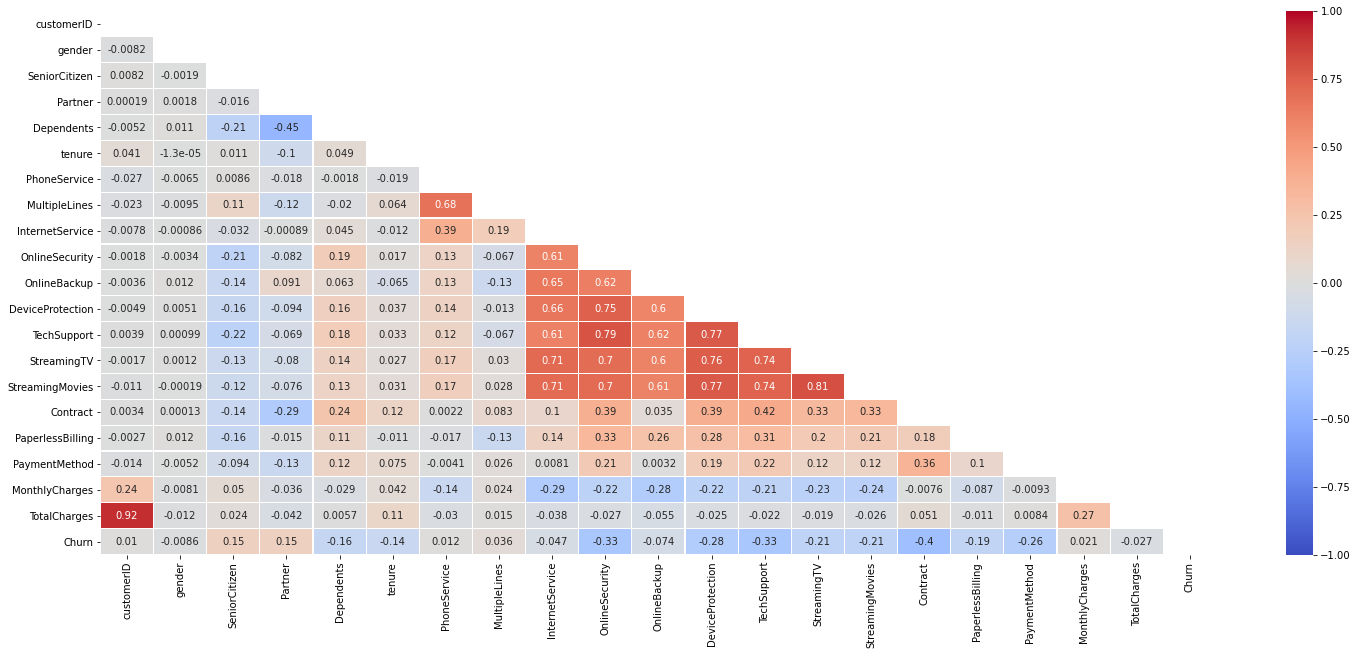

In [133]:
plt.figure(figsize=(25, 10))

corr = telecom_cust.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

# Machine Learning Model Evaluations and Predictions

In [139]:
telecom_cust = telecom_cust.iloc[:,1:]

y = telecom_cust['Churn'].values
x = telecom_cust.drop(columns=['Churn'])

In [140]:
from sklearn.model_selection import train_test_split
from sklearn import metrics


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


### KNN

In [141]:
#KNN model
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors = 11) 

knn_pipeline = Pipeline(
steps=[("preprocessor", preprocessor), ("classifier", model_knn)]
)

knn_pipeline.fit(X_train,y_train)
#predicted_y = model_knn.predict(X_test)

prediction_val = knn_pipeline.predict(X_val)
print ('validation accuracy',metrics.accuracy_score(y_val, prediction_val))


validation accuracy 0.7853589196872779


### Decision Tree

In [142]:
from sklearn.tree import DecisionTreeClassifier


model_DecTree = DecisionTreeClassifier()

DecTree_pipeline = Pipeline(
steps=[("preprocessor", preprocessor_tree), ("classifier", model_DecTree)]
)

DecTree_pipeline.fit(X_train, y_train)
predictdt_y = DecTree_pipeline.predict(X_val)
print("validation accuracy",metrics.accuracy_score(y_val, predictdt_y))
#validation accuracy 0.7268188302425107


validation accuracy 0.7377398720682303


### SVM

In [159]:
from sklearn.svm import SVC


model_svc = SVC(random_state = 1, probability=True)

svc_pipeline = Pipeline(
steps=[("preprocessor", preprocessor), ("classifier", model_svc)]
)

svc_pipeline.fit(X_train,y_train)

#predict_y = model_svc.predict(X_test_scaled)

prediction_val = svc_pipeline.predict(X_val)

print ('validation accuracy',metrics.accuracy_score(y_val, prediction_val))


validation accuracy 0.8073916133617626


### Logistic regression

In [144]:
# logistic regression model

from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=1000)


lr_pipeline = Pipeline(
steps=[("preprocessor", preprocessor), ("classifier", model_lr)]
)

lr_pipeline.fit(X_train, y_train)

prediction_val = lr_pipeline.predict(X_val)
print ('validation accuracy',metrics.accuracy_score(y_val, prediction_val))



validation accuracy 0.8102345415778252


### Random Forest

In [145]:
#  random forest model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
rf_pipeline = Pipeline(
steps=[("preprocessor", preprocessor_tree), ("classifier", model_rf)]
)


rf_pipeline.fit(X_train, y_train)

# Make predictions
prediction_val = rf_pipeline.predict(X_val)
print ('validation accuracy',metrics.accuracy_score(y_val, prediction_val))


#0.8017118402282454


validation accuracy 0.8045486851457001


### AdaBoost

In [146]:
# adaboost model
from sklearn.ensemble import AdaBoostClassifier

model_adaB = AdaBoostClassifier()

adaB_pipeline = Pipeline(
steps=[("preprocessor", preprocessor_tree), ("classifier", model_adaB)]
)

adaB_pipeline.fit(X_train, y_train)
prediction_val = adaB_pipeline.predict(X_val)

print ('validation accuracy',metrics.accuracy_score(y_val, prediction_val))


validation accuracy 0.7967306325515281


## Try the best models so far on test data (logistic, random forest, adaboost)

### 1. logistic regression

In [147]:
prediction_test = lr_pipeline.predict(X_test)
evaluation_metrics(y_test, prediction_test)


accuracy: 0.7953091684434968
precision: 0.6234177215189873
recall: 0.5382513661202186
f1_score 0.5777126099706744
specificity: 0.8856868395773295


### ROC curve

Best Threshold=0.247853, G-Mean=0.773
0.8524590163934426


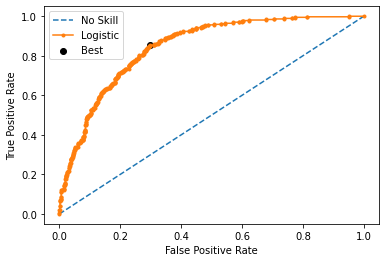

In [148]:
draw_roc(lr_pipeline, X_test, y_test)

### tune for better recall

In [149]:
y_pred_lr = pred_with_threshold(lr_pipeline, X_test, y_test)
y_pred_lr = ['Yes' if x == 1  else 'No' for x in y_pred_lr]
evaluation_metrics(y_test, y_pred_lr)


accuracy: 0.7405828002842928
precision: 0.5008025682182986
recall: 0.8524590163934426
f1_score 0.6309403437815977
specificity: 0.7012487992315082


### 2. Random Forest

In [150]:
prediction_test = rf_pipeline.predict(X_test)
evaluation_metrics(y_test, prediction_test)


accuracy: 0.7981520966595593
precision: 0.6576923076923077
recall: 0.4672131147540984
f1_score 0.5463258785942492
specificity: 0.914505283381364


### ROC curve

Best Threshold=0.279959, G-Mean=0.779
0.8278688524590164


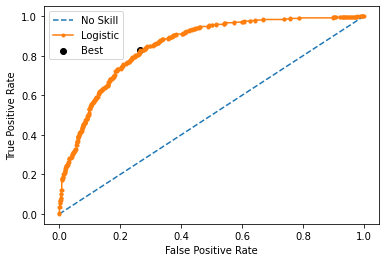

In [151]:
draw_roc(rf_pipeline, X_test, y_test)

### tune for better recall (choose best trade-off point on ROC curve as shown on graph)

In [152]:
y_pred_rf = pred_with_threshold(rf_pipeline, X_test, y_test)
y_pred_rf = ['Yes' if x == 1  else 'No' for x in y_pred_rf]

evaluation_metrics(y_test, y_pred_rf)


accuracy: 0.7583511016346838
precision: 0.5224137931034483
recall: 0.8278688524590164
f1_score 0.6405919661733614
specificity: 0.733909702209414


## 3. AdaBoost

In [153]:
prediction_test = adaB_pipeline.predict(X_test)

evaluation_metrics(y_test, prediction_test)


accuracy: 0.7938877043354655
precision: 0.6283783783783784
recall: 0.5081967213114754
f1_score 0.5619335347432025
specificity: 0.8943323727185398


### ROC curve

Best Threshold=0.493585, G-Mean=0.774
0.8934426229508197


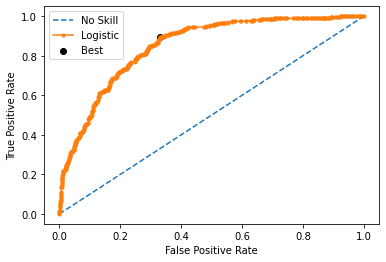

In [154]:
draw_roc(adaB_pipeline, X_test, y_test)

### tune for better recall

In [155]:
y_pred_adaB = pred_with_threshold(adaB_pipeline, X_test, y_test)
y_pred_adaB = ['Yes' if x == 1  else 'No' for x in y_pred_adaB]

evaluation_metrics(y_test, y_pred_adaB)


accuracy: 0.728500355366027
precision: 0.4880597014925373
recall: 0.8934426229508197
f1_score 0.6312741312741313
specificity: 0.6705091258405379


## 4. SVC

In [160]:
prediction_test = svc_pipeline.predict(X_test)

evaluation_metrics(y_test, prediction_test)


accuracy: 0.7945984363894811
precision: 0.6296296296296297
recall: 0.5109289617486339
f1_score 0.564102564102564
specificity: 0.8943323727185398


### ROC curve

Best Threshold=0.163306, G-Mean=0.746
0.7923497267759563


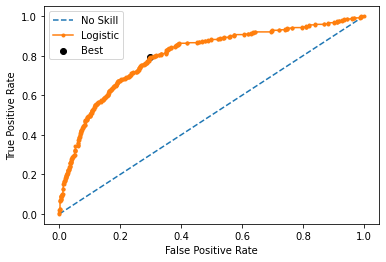

In [161]:
draw_roc(svc_pipeline, X_test, y_test)

### tune for better recall

In [162]:
y_pred_svc = pred_with_threshold(svc_pipeline, X_test, y_test)
y_pred_svc = ['Yes' if x == 1  else 'No' for x in y_pred_svc]

evaluation_metrics(y_test, y_pred_svc)


accuracy: 0.7263681592039801
precision: 0.48414023372287146
recall: 0.7923497267759563
f1_score 0.6010362694300518
specificity: 0.7031700288184438


# My Custom functions

In [78]:
# function for ROC curve

from numpy import argmax
from numpy import sqrt

def draw_roc(model, xtest, ytest):
    probs = model.predict_proba(xtest)

    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(ytest, probs, pos_label='Yes')
    
    # calculate the g-mean for each threshold

    gmeans = sqrt(tpr * (1-fpr))
    
    # locate the index of the largest g-mean

    ix = argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    # plot the roc curve for the model
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    print(tpr[ix])
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    #return y_pred

In [73]:
# function for confusion matrix and metrics.
def pred_with_threshold(model, xtest, ytest):
    probs = model.predict_proba(xtest)

    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(ytest, probs, pos_label='Yes')
    
    # calculate the g-mean for each threshold
    gmeans = sqrt(tpr * (1-fpr))
    
    # locate the index of the largest g-mean
    ix = argmax(gmeans)

    y_pred = (probs >= thresholds[ix]).astype(int)
    
    return y_pred

    

In [77]:
# function for evaluation metrics
def evaluation_metrics(ytest, ypred):
    tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()
    print ('accuracy:',metrics.accuracy_score(ytest, ypred))
    print('precision:',precision_score(ytest, ypred, pos_label='Yes'))
    print('recall:',recall_score(ytest, ypred, pos_label='Yes'))
    print('f1_score',f1_score(ytest, ypred, pos_label='Yes'))
    print('specificity:',tn/(tn+fp))


In [75]:
def bar_with_churn_label(df,col):
    colors = ['#636EFA','#EF553B']
    contract_churn = df.groupby([col,'Churn']).size().unstack()

    ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = False,
                                                                rot = 0, 
                                                                figsize = (22,13),
                                                                color = colors)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend(loc='best',prop={'size':14},title = 'Churn')
    ax.set_ylabel('% Customers',size = 14)
    title = 'Churn by ' + col
    ax.set_title(title,size = 14)

    # Code to add the data labels on the stacked bar chart
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                    color = 'white',
                   weight = 'bold',
                   size = 14)


In [76]:
def draw_hist(df,colname):
    colors = ['#cd5c5c','#2e8b57']
    ax = (df['Churn'].value_counts()*100.0 /len(df)).plot(kind='bar',
                                                                           stacked = False,
                                                                          rot = 0,
                                                                          color = colors,
                                                                         figsize = (8,6))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylabel('% Customers',size = 14)
    ax.set_xlabel('Churn',size = 14)
    ax.set_title('Churn Rate', size = 14)

    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_x()+.15, i.get_height()-4.0, \
                str(round((i.get_height()/total), 1))+'%',
                fontsize=12,
                color='white',
               weight = 'bold',
               size = 14)
